In [12]:
# importing libraries
import numpy as np                      
import matplotlib.pyplot as plt         
from PIL import Image, ImageOps         
from statistics import mean
import math

In [13]:
# loading the input dataset (data extracted to "dataset1" folder)
input_data = np.array([list(Image.open('Dataset1/s'+str(i+1)+'/'+str(j+1)+'.pgm').convert('L').getdata()) for j in range(10) for i in range(40)])

# Splitting the input dataset(400 images) to training set 60%(240) and testing set 40%(160)
train_set = input_data[:240]
test_set = input_data[240:]

In [14]:
# calculating the mean image of training set
Mean = np.array([mean([p[k] for p in train_set]) for k in range(92*112)])

# calculating mean zero matrix for train_set
mean_cent_train_set = np.array([p - Mean for p in train_set])

# calculating mean zero matrix for test_set                             
mean_cent_test_set = np.array([p - Mean for p in test_set])  

# calculating co-variance matrix
cov_mat = np.matmul(mean_cent_train_set, mean_cent_train_set.T) / len(mean_cent_train_set)   

# calculating eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)  

# sorting the eigenvectors based on eigenvalues
index = eigen_values.argsort()[::-1]
eigen_values = eigen_values[index]
eigen_vectors = eigen_vectors[:, index]

In [18]:
# from the observation of PCA accuracy k is choosen
k=19

# taking the feature vector based on k value
feature_vector = eigen_vectors[:, :k]    

# calculating eigen faces of train_set
eigen_faces = np.matmul(feature_vector.T, mean_cent_train_set )          

# calculating eigen face signatures of train_set
eigen_signatures = np.matmul(eigen_faces, mean_cent_train_set.T)   


In [19]:
#------------------------ANN------------------------------------

# training_set for ANN
x = eigen_signatures

# no.of neurons in hidden layer
n=360

# no of clases (no of nodes in outer layer)
c=40

# Random weights for hidden and outer layer
wt_h = np.random.uniform(-0.5,0.5,size=(k,n))
wt_o = np.random.uniform(-0.5,0.5,size=(n,c))

# To store error of hidden and outer layer
er_h = np.zeros(shape=(n), dtype=np.float64) 
er_o = np.zeros(shape=(c), dtype=np.float64) 

# Random threshold values for hidden and outer layer
th_h = np.random.uniform(.10,1.0,size=(n))
th_o = np.random.uniform(.10,1.0,size=(c))

# To store actual outputs of hidden and outer layer
y_h = np.zeros(shape=(n), dtype=np.float64) 
y_o = np.zeros(shape=(c), dtype=np.float64)

# learning rate
alpha = np.random.uniform(.1,1.0)

# let initialize cost funtion
e=1

# To count the no of epochs(loops)
epochs=0

# To store accuracy and cost function values for different epochs
ep=[]
acc=[]
cost_func=[]


while e > 0.001 :
    
    # initialzing cost function for every epoch
    e=0
    
    # for every image in training set
    for i in range(len(x[1])):
        
        # calculating actual output of hidden layer
        for j in range(n):
            y_h[j] = 1 / (1 + np.exp( -1*(x[:,i] @ wt_h[:,j] - th_h[j]) ))

        # calculating actual output of outer layer
        for j in range(c):
            y_o[j] = 1 / (1 + np.exp( -1*(y_h @ wt_o[:,j] - th_o[j]) ))

        # expected output or correct output
        req_out = np.zeros(shape=(c),dtype=np.float64)
        req_out[int(i%40)] = 1

        # Adding to cost to Cost function for every image
        e += (req_out - y_o) @ (req_out - y_o)

        # Errors of outer layer
        er_o = y_o*(1 - y_o)*(req_out - y_o)
        
        # errors of hidden layer
        for j in range(n):
            er_h[j] = y_h[j]*(1-y_h[j])*(er_o @ wt_o[j,:])

        # correction in hidden layer weights        
        for j in range(n):
            wt_h[:,j] = wt_h[:,j] + alpha*x[:,i]*er_h[j]

        # correction in outer layer weights
        for j in range(c):
            wt_o[:,j] = wt_o[:,j] + alpha*y_h*er_o[j]

        # correction in hidden layer threshold       
        th_h = th_h + alpha*(-1)*er_h

        # correction in output layer threshold 
        th_o = th_o + alpha*(-1)*er_o


    # incrementing epoch
    epochs+=1
    
    # calculating accuracy for every 25 epochs
    # testing for every 25 epochs
    if epochs%25 == 0:
        
        # to store the count of wrong predictions
        wrng = 0
        
        # to store actual output of hidden and outer layers of test set 
        y_ht = np.zeros(shape=(n), dtype=np.float64) 
        y_ot = np.zeros(shape=(c), dtype=np.float64)
        
        for l in range(len(mean_cent_test_set)):
            
            # test image vector to compare with eigen signatures
            test_img = eigen_faces @ mean_cent_test_set[l]

            # calculating actual ouput of hidden layer of test_set
            for j in range(n):
                y_ht[j] = 1 / (1 + np.exp( -1*(test_img @ wt_h[:,j] - th_h[j]) ))

            # calculating actual ouput of outer layer of test_set 
            for j in range(c):
                y_ot[j] = 1 / (1 + np.exp( -1*(y_ht @ wt_o[:,j] - th_o[j]) ))
            
            # finding the prediction of class it belongs to.
            index = np.argmax(y_ot)
            
            # incrementing if predicted wrong
            if index != int(l%40):
                wrng+=1

        acc.append((160-wrng)/160)
        ep.append(epochs)
        cost_func.append(e)
        print("epoch - ",epochs," cost function - ",e," accuracy - ",acc[-1])
    
    # breaking the loop for 1500 epochs
    if epochs>1500:
        break


C:\Users\Thanoj kumar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:53: RuntimeWarning: overflow encountered in exp
C:\Users\Thanoj kumar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:109: RuntimeWarning: overflow encountered in exp


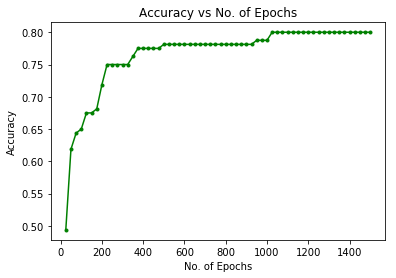

In [21]:
# plotting Accuracy vs epoch values
plt.plot(ep,acc,'.g-')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs No. of Epochs')
plt.show()

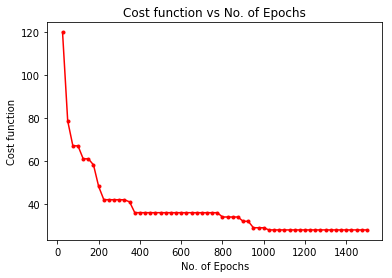

In [22]:
# plotting cost function vs epoch values
plt.plot(ep,cost_func,'.r-')
plt.xlabel('No. of Epochs')
plt.ylabel('Cost function')
plt.title('Cost function vs No. of Epochs')
plt.show()

In [24]:
# From the plots, it is clear that:
#  a. Accuracy increases with increase in no. of epochs.
#  b. Cost function(loss) dereases with increase in no. of epochs.
#  c. Accuracy increases with decrease in cost function.